## SFC Meteorology Obs from:
** - 2018/2019 M2 (BSITAEPR-2A) **   
*** - 2011-2019 M2 (BSM-2A : argo feed) ***   
*** - 20??-2019 M2 (BSM-2A : final data) ***

__pyversion__==3.6   
__author__==S.Bell

In [20]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-07-12 09:39:58.039379


### connecting to erddap and retrieving and basic information

In [21]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [22]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='bsitaepr2a_met'))

In [23]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 2 tabledap, 0 griddap, and 0 wms endpoints.'

In [24]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_18bsitaepr2a_met' 'erddap_19bsitaepr2a_met']


In [25]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['relative_humidity', 'wind_speed', 'longitude', 'time', 'wind_from_direction', 'latitude', 'eastward_wind', 'air_temperature', 'northward_wind', 'air_pressure'], ['relative_humidity', 'time', 'latitude', 'eastward_wind', 'air_temperature', 'northward_wind', 'longitude', 'air_pressure']]


### getting Peggy Buoy (BSM-2A) Data

In [26]:
wdf = pd.read_csv('http://pavlof.pmel.noaa.gov/bell/ArgosMooring/data/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

adf = pd.read_csv('/Users/bell/scratch/bsm2a_wpak.csv',
                 parse_dates=True,index_col='date')

In [27]:
wdf = wdf.resample('1H').mean()
adf = adf.resample('1H').mean()

### retrieving erddap and plotting data

In [28]:
constraints = {
    'time>=': '2017-04-25T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
# 'wind_from_direction', 
 'air_temperature',
 'relative_humidity',
 'northward_wind', 
 'eastward_wind', 
# 'wind_speed', 
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_18bsitaepr2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_19bsitaepr2a_met:
timeseries_id,latitude,longitude,time,northward_wind,air_pressure,relative_humidity,air_temperature,eastward_wind


In [29]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_19bsitaepr2a_met','erddap_18bsitaepr2a_met']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            if row['Dataset ID'] in ['erddap_19bsitaepr2a_met','erddap_18bsitaepr2a_met']:
                e.variables=variables + ['air_pressure']
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time (UTC)',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_18bsitaepr2a_met
erddap_19bsitaepr2a_met


In [30]:
df=dfs['erddap_19bsitaepr2a_met']
df.columns

Index(['air_temperature', 'relative_humidity', 'northward_wind',
       'eastward_wind', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'air_pressure'],
      dtype='object')

### Take care of any preliminary QC

In [31]:
#calculate windspeed and direction
for ds, df in dfs.items():
    try:
        df['wind_speed (m s-1)']=np.sqrt(df['northward_wind']**2 + df['eastward_wind']**2)
        df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind'],
                                                                     df['eastward_wind']))

        df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360
    except:
        df['wind_speed (m s-1)']=np.sqrt(df['northward_wind (m s-1)']**2 + df['eastward_wind (m s-1)']**2)
        df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind (m s-1)'],
                                                                     df['eastward_wind (m s-1)']))

        df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360
        

In [32]:
#eliminate unlikely wind and pressure extremes
for ds, df in dfs.items():
    df['wind_speed (m s-1)'][df['wind_speed (m s-1)']>100] = np.nan
    try:
        df['air_pressure'][df['air_pressure']<940] = np.nan
    except:
        df['air_pressure (mbar)'][df['air_pressure (mbar)']<940] = np.nan
    try:
        df['air_temperature'][df['air_temperature']>150] = np.nan
    except:
        df['air_temperature (degree_C)'][df['air_temperature (degree_C)']>=100] = np.nan

#Arbitrary QC points based on evaluating plot / local characteristics and not broad science boundaries
wdf.WS[wdf.WS>25] = np.nan
wdf.RH[wdf.RH<25] = np.nan
wdf.BP[wdf.BP<975] = np.nan

### Plot

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [34]:
wdf.index.hour/24

Float64Index([  0.5416666666666666,   0.5833333333333334,                0.625,
                0.6666666666666666,   0.7083333333333334,                 0.75,
                0.7916666666666666,   0.8333333333333334,                0.875,
                0.9166666666666666,
              ...
                0.9166666666666666,   0.9583333333333334,                  0.0,
              0.041666666666666664,  0.08333333333333333,                0.125,
               0.16666666666666666,  0.20833333333333334,                 0.25,
                0.2916666666666667],
             dtype='float64', name='sampletime', length=1819)

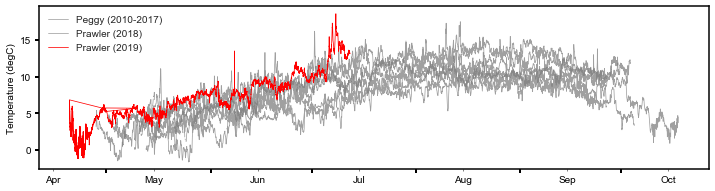

In [52]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(adf.index.dayofyear+adf.index.hour/24,adf['AT'],'grey',alpha=.75,linewidth=.75)

for ds, df in dfs.items():
    try:
        plt.plot(df.index.dayofyear+df.index.hour/24+df.index.minute/(24*60),df['air_temperature'],'red',linewidth=.75)
        plt.ylabel('Temperature (degC)')
    except:
        plt.plot(df.index.dayofyear+df.index.hour/24+df.index.minute/(24*60),df['air_temperature (degree_C)'],
                 'grey',alpha=.75,linewidth=.75)

plt.legend(['Peggy (2010-2017)','Prawler (2018)','Prawler (2019)'])
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1]))
ax.xaxis.set_minor_locator(DayLocator(range(0,28,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%b'))
ax.xaxis.set_major_formatter(DateFormatter(''))

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


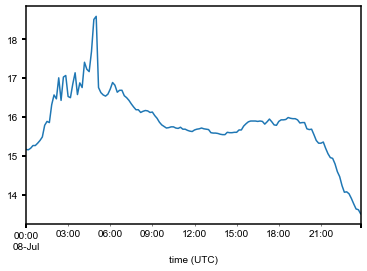

In [49]:
df['2019-7-8'].air_temperature.plot()